In [1]:
import numpy as np 
import pandas as pd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [2]:
df = pd.read_csv("omnii data cleaned ready finale.csv")

In [3]:
df[["Year","Day","Hour"]]

,Year,Day,Hour
0,1963,1.0,0
1,1963,1.0,1
2,1963,1.0,2
3,1963,1.0,3
4,1963,1.0,4
...,...,...,...
532353,2023,365.0,19
532354,2023,365.0,20
532355,2023,365.0,21
532356,2023,365.0,22


In [4]:
df["date"] = pd.to_datetime(df['Year'].astype(int).astype(str) + '-' + df['Day'].astype(int).astype(str) + '-' + df['Hour'].astype(int).astype(str), format='%Y-%j-%H')
df = df.drop(["Unnamed: 0","Year","Day","Hour"], axis=1)

In [5]:
df = df.dropna()

In [6]:
df = df.sort_values("date").reset_index(drop=True)

In [7]:
target = df[["Kp*10"]]
X = df.drop(["Kp*10"],axis = 1)

# Trial 1

In [8]:
# Define scaling factors
D_Attacker = 0.1  # Adjust this value based on the sensitivity of the Attacker's movement
D_Barrier = 0.1   # Adjust this value based on the sensitivity of the Barrier's movement
D_Chaser = 0.1    # Adjust this value based on the sensitivity of the Chaser's movement
D_Driver = 0.1    # Adjust this value based on the sensitivity of the Driver's movement

def initialization(SearchAgents_no, dim, ub, lb):
    # Initialize the positions of search agents
    return np.random.uniform(lb, ub, (SearchAgents_no, dim))
def random_coefficients():
    return np.random.rand()
def logistic_map(seed, iterations, r):
    chaotic_sequence = [seed]
    for _ in range(iterations):
        new_value = chaotic_map(chaotic_sequence[-1], r)
        chaotic_sequence.append(new_value)
    return chaotic_sequence[1:]

def chaos(n, m, a, x, r):
    # Implement your chaotic map function here
    return r * x * (1 - x)

def fitness_function(position, X_train, y_train, X_test, y_test, model):
    # Assuming you have a function to calculate fitness for your problem
    weights_shapes = [w.shape for w in model.get_weights()]
    num_weights = sum(np.prod(shape) for shape in weights_shapes)
    
    print("Number of weights in the model:", num_weights)
    print("Size of the position vector:", position.size)
    
    if position.size != num_weights:
        raise ValueError("Position size does not match the number of weights.")
    
    reshaped_weights = []
    index = 0
    for shape in weights_shapes:
        reshaped_weights.append(position[index:index + np.prod(shape)].reshape(shape))
        index += np.prod(shape)
    
    model.set_weights(reshaped_weights)  # Set model weights
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

def coa(X_train, y_train, X_test, y_test, model, Max_iter=100, SearchAgents_no=10):
    # Define the COA optimization algorithm
    num_weights = model.count_params()
    lb = -1  # Assuming lower bound
    ub = 1   # Assuming upper bound
    
    # Initialize Attacker, Barrier, Chaser, and Driver
    Attacker_pos = np.zeros(num_weights)
    Attacker_score = np.inf  # change this to -np.inf for maximization problems
    Barrier_pos = np.zeros(num_weights)
    Barrier_score = np.inf  # change this to -np.inf for maximization problems
    Chaser_pos = np.zeros(num_weights)
    Chaser_score = np.inf  # change this to -np.inf for maximization problems
    Driver_pos = np.zeros(num_weights)
    Driver_score = np.inf  # change this to -np.inf for maximization problems
    
    Positions = initialization(SearchAgents_no, num_weights, ub, lb)
    
    Convergence_curve = np.zeros(Max_iter)
    l = 0  # Loop counter
    
    # Main loop
    while l < Max_iter:
        for i in range(Positions.shape[0]):
            # Return back the search agents that go beyond the boundaries of the search space
            Flag4ub = Positions[i, :] > ub
            Flag4lb = Positions[i, :] < lb
            Positions[i, :] = (Positions[i, :] * (~(Flag4ub + Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            
            # Calculate objective function for each search agent
            fitness = fitness_function(Positions[i, :], X_train, y_train, X_test, y_test, model)
            
            # Update Attacker, Barrier, Chaser, and Driver
            if fitness < Attacker_score:
                Attacker_score = fitness
                Attacker_pos = Positions[i, :]
            
            if Attacker_score < fitness < Barrier_score:
                Barrier_score = fitness
                Barrier_pos = Positions[i, :]
            
            if Barrier_score < fitness < Chaser_score:
                Chaser_score = fitness
                Chaser_pos = Positions[i, :]
                
            if Chaser_score < fitness < Driver_score:
                Driver_score = fitness
                Driver_pos = Positions[i, :]
        
        # Update the Position of search agents including omegas
        f = 2 - l * ((2) / Max_iter)  # a decreases linearly from 2 to 0
        
        # Update coefficients based on the current iteration count
        # Assuming you have coefficients update strategies for different groups
        
        for i in range(Positions.shape[0]):
            for j in range(Positions.shape[1]):
                r = random_coefficients() # Where is the definition of random_coefficients() function?
                A = 2 * f * r - f
                m = chaos(3, 1, 1, X_train, r)
                
                X1 = Attacker_pos[j] - A * D_Attacker # Where is the definition of D_Attacker?
                X2 = Barrier_pos[j] - A * D_Barrier # Where is the definition of D_Barrier?
                X3 = Chaser_pos[j] - A * D_Chaser # Where is the definition of D_Chaser?
                X4 = Driver_pos[j] - A * D_Driver # Where is the definition of D_Driver?
                
                Positions[i, j] = (X1 + X2 + X3 + X4) / 4
        
        l += 1
        Convergence_curve[l] = Attacker_score
    
    return Attacker_score, Attacker_pos, Convergence_curve

In [ ]:
if __name__ == "__main__":

    # Scale the features
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(X.drop(["date"], axis=1)), columns=X.drop(["date"], axis=1).columns)

    # Split the data into training and test sets in order
    train_size = int(len(df_scaled) * 0.8)
    X_train, X_test = df_scaled[:train_size], df_scaled[train_size:]
    y_train, y_test = target[:train_size], target[train_size:]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    print("*" * 20)
    print("start Training")
    print("*" * 20)

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # Fit the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                        validation_data=(X_test, y_test))
    
    # Perform COA optimization
    Attacker_score, Attacker_pos, Convergence_curve = coa(X_train, y_train, X_test, y_test, model=model)
    print("Best score:", Attacker_score)
    print("Best position:", Attacker_pos)

********************
start Training
********************


Epoch 1/10

5340/5340 [==============================] - 16s 3ms/step - loss: 5.6464 - val_loss: 2.3701
Epoch 2/10
5340/5340 [==============================] - 13s 3ms/step - loss: 1.7356 - val_loss: 1.6125
Epoch 3/10
5340/5340 [==============================] - 12s 2ms/step - loss: 1.3410 - val_loss: 1.3618
Epoch 4/10
5340/5340 [==============================] - 12s 2ms/step - loss: 1.0848 - val_loss: 1.1285
Epoch 5/10
5340/5340 [==============================] - 12s 2ms/step - loss: 0.9289 - val_loss: 1.0374
Epoch 6/10
5340/5340 [==============================] - 13s 2ms/step - loss: 0.8373 - val_loss: 0.9551
Epoch 7/10
5340/5340 [==============================] - 13s 3ms/step - loss: 0.7746 - val_loss: 0.8823
Epoch 8/10
5340/5340 [==============================] - 13s 2ms/step - loss: 0.7256 - val_loss: 1.0341
Epoch 9/10
5340/5340 [==============================] - 13s 2ms/step - loss: 0.6867 - val_loss: 0.8760
Epoch 10/10
5

# LSTM - CHIMP

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Define chaos function
def chaos(index, max_iter, Value):
    x = np.zeros(max_iter+1)
    x[0] = 0.7
    G = np.zeros(max_iter)
    
    if index == 1:
        for i in range(max_iter):
            x[i+1] = np.cos(i * np.arccos(x[i]))
            G[i] = ((x[i] + 1) * Value) / 2
    elif index == 2:
        a = 0.5
        b = 0.2
        for i in range(max_iter):
            x[i+1] = np.mod(x[i] + b - (a / (2 * np.pi)) * np.sin(2 * np.pi * x[i]), 1)
            G[i] = x[i] * Value
    # Implement other cases for different chaos functions
    return G

# Define Chimp optimization function
def Chimp(SearchAgents_no, Max_iter, lb, ub, dim, fobj):
    Attacker_pos = np.zeros(dim)
    Attacker_score = np.inf
    
    # Initialize other variables
    Barrier_pos = np.zeros(dim)
    Barrier_score = np.inf
    Chaser_pos = np.zeros(dim)
    Chaser_score = np.inf
    Driver_pos = np.zeros(dim)
    Driver_score = np.inf
    
    # Initialize the positions of search agents
    Positions = initialization(SearchAgents_no, dim, ub, lb)
    
    Convergence_curve = np.zeros(Max_iter)
    
    for l in range(Max_iter):
        for i in range(SearchAgents_no):
            # Calculate fitness for each search agent
            fitness = fobj(Positions[i])
            
            # Update best positions and scores
            if fitness < Attacker_score:
                Attacker_score = fitness
                Attacker_pos = Positions[i]
        
        # Update convergence curve
        Convergence_curve[l] = Attacker_score
        
        # Update positions using Chimp algorithm
        
        l += 1
    
    return Attacker_score, Attacker_pos, Convergence_curve

# Define initialization function
def initialization(SearchAgents_no, dim, ub, lb):
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(SearchAgents_no):
        Positions[i, :] = lb + (ub - lb) * np.random.rand(dim)
    return Positions

# Define objective function for Chimp optimization
def objective_function(params):
    # Extract parameters for LSTM model
    learning_rate, batch_size, epochs = params
    
    # Construct and train LSTM model using the parameters
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

# Function to evaluate the LSTM model's performance
def evaluate_model(X_train, y_train, X_test, y_test, params):
    # Extract parameters for LSTM model
    learning_rate, batch_size, epochs = params
    
    # Construct and train LSTM model using the parameters
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

In [11]:
#Scale the features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X.drop(["date"], axis=1)), columns=X.drop(["date"], axis=1).columns)

# Split the data into training and test sets
train_size = int(len(df_scaled) * 0.8)
X_train, X_test = df_scaled[:train_size], df_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define search space for Chimp optimization (e.g., learning rate, batch size, epochs)
lb = np.array([0.001, 32, 10])  # Lower bounds for parameters
ub = np.array([0.01, 128, 100])  # Upper bounds for parameters
dim = len(lb)  # Dimension of the search space

# Define other hyperparameters for Chimp optimization
SearchAgents_no = 30
Max_iter = 1

# Initialize search agents
Positions = initialization(SearchAgents_no, dim, ub, lb)

# Run Chimp optimization to find optimal parameters for LSTM
Attacker_score, Attacker_pos, Convergence_curve = Chimp(SearchAgents_no, Max_iter, lb, ub, dim, objective_function)

# Extract optimal parameters for LSTM model
best_params = Attacker_pos

2670/2670 [==============================] - 3s 1ms/step - loss: 0.3859


Epoch 1/95
7120/7120 [==============================] - 18s 2ms/step - loss: 4.7762 - val_loss: 2.0339
Epoch 2/95
7120/7120 [==============================] - 16s 2ms/step - loss: 1.5460 - val_loss: 1.4591
Epoch 3/95
7120/7120 [==============================] - 16s 2ms/step - loss: 1.1840 - val_loss: 1.2729
Epoch 4/95
7120/7120 [==============================] - 17s 2ms/step - loss: 0.9641 - val_loss: 1.0510
Epoch 5/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.8434 - val_loss: 0.9322
Epoch 6/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.7675 - val_loss: 0.9034
Epoch 7/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.7119 - val_loss: 0.8267
Epoch 8/95
7120/7120 [==============================] - 17s 2ms/step - loss: 0.6693 - val_loss: 0.7787
Epoch 9/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.6345 - val_loss: 0.7339
Epoch 10/95
7120/7120 [==============================] - 16s 2ms/step - l

Epoch 80/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2816 - val_loss: 0.3326
Epoch 81/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2803 - val_loss: 0.3293
Epoch 82/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2800 - val_loss: 0.3285
Epoch 83/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2784 - val_loss: 0.3276
Epoch 84/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2778 - val_loss: 0.3224
Epoch 85/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2771 - val_loss: 0.3228
Epoch 86/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2784 - val_loss: 0.3350
Epoch 87/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2756 - val_loss: 0.3319
Epoch 88/95
7120/7120 [==============================] - 16s 2ms/step - loss: 0.2758 - val_loss: 0.3649
Epoch 89/95
7120/7120 [==============================] - 16s 2ms

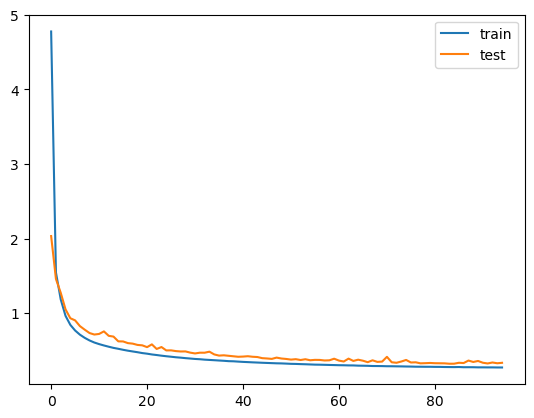

2670/2670 [==============================] - 4s 1ms/step
Mean Absolute Error (MAE): 0.3348413905226554


In [14]:
from tensorflow.keras import optimizers
# 1. Update the LSTM model with the new parameters
learning_rate = Attacker_pos[0]  # learning rate
batch_size = int(Attacker_pos[1])  # batch size (convert to integer)
epochs = int(Attacker_pos[2])  # number of epochs (convert to integer)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=optimizers.Adam(lr=learning_rate))

# 2. Train the LSTM model using the updated parameters
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# 3. Plot the new loss curve based on the training process
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. Calculate the Mean Absolute Error (MAE) using the updated model
y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error (MAE):", mae)

In [13]:
best_params

array([7.49824797e-03, 4.89939278e+01, 9.57976707e+01])

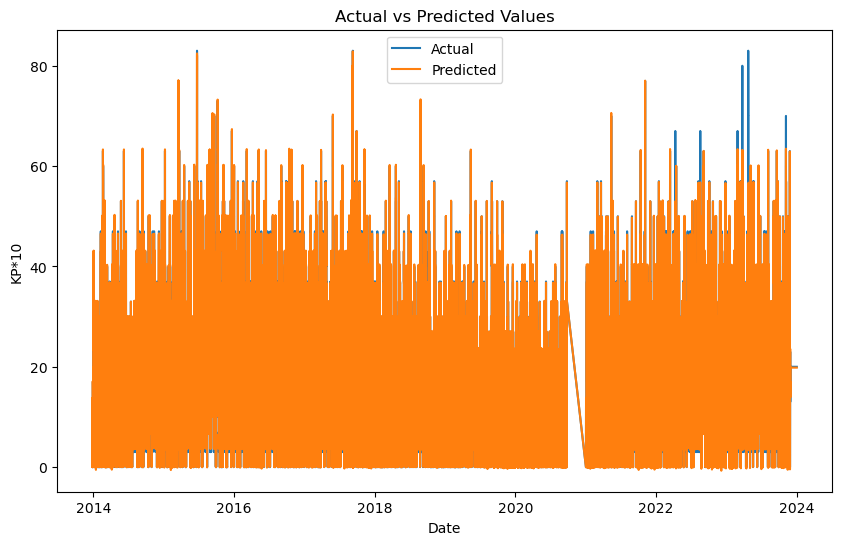

In [15]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Actual': np.array(y_test).flatten(), 
                        'Predicted': np.array(y_pred).flatten()
                       },
                       index=X['date'][train_size:])


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Actual'], label='Actual')
plt.plot(df_plot['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('KP*10')
plt.legend()
plt.show()

# GRU - CHIMP

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
import numpy as np

# Define objective function for Chimp optimization
def objective_function(params):
    # Extract parameters for GRU model
    learning_rate, batch_size, epochs = params
    
    # Construct and train GRU model using the parameters
    model = Sequential()
    model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

# Function to evaluate the GRU model's performance
def evaluate_model(X_train, y_train, X_test, y_test, params):
    # Extract parameters for GRU model
    learning_rate, batch_size, epochs = params
    
    # Construct and train GRU model using the parameters
    model = Sequential()
    model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

In [17]:
#Scale the features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X.drop(["date"], axis=1)), columns=X.drop(["date"], axis=1).columns)

# Split the data into training and test sets
train_size = int(len(df_scaled) * 0.8)
X_train, X_test = df_scaled[:train_size], df_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define search space for Chimp optimization (e.g., learning rate, batch size, epochs)
lb = np.array([0.001, 32, 10])  # Lower bounds for parameters
ub = np.array([0.01, 128, 100])  # Upper bounds for parameters
dim = len(lb)  # Dimension of the search space

# Define other hyperparameters for Chimp optimization
SearchAgents_no = 30
Max_iter = 1

# Initialize search agents
Positions = initialization(SearchAgents_no, dim, ub, lb)

# Run Chimp optimization to find optimal parameters for LSTM
Attacker_score, Attacker_pos, Convergence_curve = Chimp(SearchAgents_no, Max_iter, lb, ub, dim, objective_function)

# Extract optimal parameters for LSTM model
best_params = Attacker_pos

2670/2670 [==============================] - 4s 1ms/step - loss: 0.4824


In [18]:
best_params

array([6.48390496e-03, 3.39885455e+01, 7.51384365e+01])

Epoch 1/75
10356/10356 [==============================] - 28s 2ms/step - loss: 3.7993 - val_loss: 1.7953
Epoch 2/75
10356/10356 [==============================] - 25s 2ms/step - loss: 1.3948 - val_loss: 1.3647
Epoch 3/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.9821 - val_loss: 0.9674
Epoch 4/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.7708 - val_loss: 0.8436
Epoch 5/75
10356/10356 [==============================] - 26s 2ms/step - loss: 0.6553 - val_loss: 0.7214
Epoch 6/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.5835 - val_loss: 0.6793
Epoch 7/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.5337 - val_loss: 0.5982
Epoch 8/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.4948 - val_loss: 0.6333
Epoch 9/75
10356/10356 [==============================] - 25s 2ms/step - loss: 0.4639 - val_loss: 0.5400
Epoch 10/75
10356/10356 [==============================

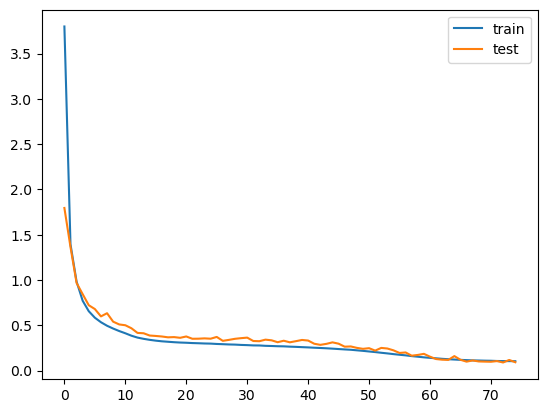

2670/2670 [==============================] - 3s 1ms/step
Mean Absolute Error (MAE): 0.09208741659143264


In [20]:
from tensorflow.keras import optimizers
# 1. Update the LSTM model with the new parameters
learning_rate = Attacker_pos[0]  # learning rate
batch_size = int(Attacker_pos[1])  # batch size (convert to integer)
epochs = int(Attacker_pos[2])  # number of epochs (convert to integer)

model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=optimizers.Adam(lr=learning_rate))

# 2. Train the LSTM model using the updated parameters
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# 3. Plot the new loss curve based on the training process
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. Calculate the Mean Absolute Error (MAE) using the updated model
y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error (MAE):", mae)

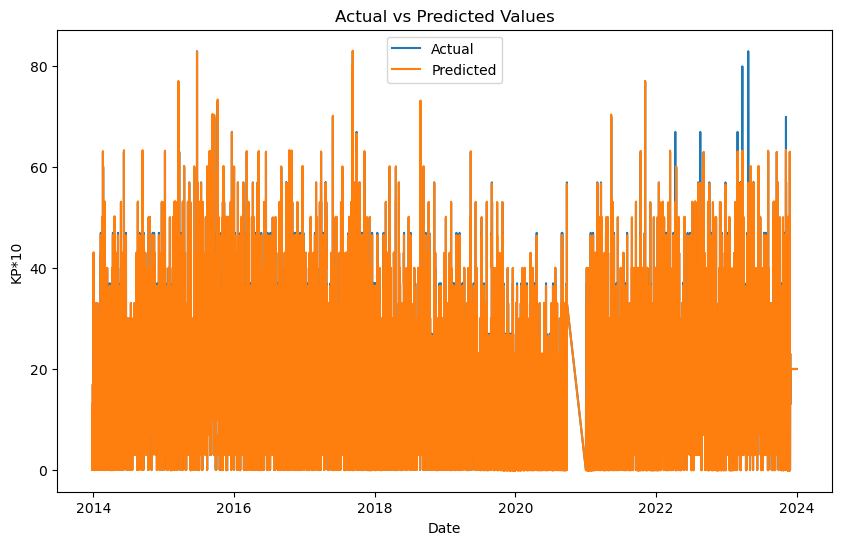

In [21]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Actual': np.array(y_test).flatten(), 
                        'Predicted': np.array(y_pred).flatten()
                       },
                       index=X['date'][train_size:])


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Actual'], label='Actual')
plt.plot(df_plot['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('KP*10')
plt.legend()
plt.show()

# LSTM + ATTENTION - CHIMP

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, Dot, Activation, RepeatVector
from tensorflow.keras import backend as K

def create_attention_model(input_shape):
    # Define input layers
    inputs = Input(shape=input_shape, name='encoder_input')
    
    # Define LSTM layer
    lstm = LSTM(50, return_sequences=True, name='encoder_lstm')(inputs)
    
    # Calculate attention weights
    attention = Dense(1, activation='tanh')(lstm)
    attention = Activation('softmax', name='attention_weights')(attention)
    
    # Apply the attention weights
    context = Dot(axes=1, name='attention_dot')([attention, lstm])
    
    # Concatenate the context with the LSTM output
    merged = Concatenate(axis=-1)([context, lstm])
    
    # Apply a Dense layer to output a single value
    output = Dense(1)(merged)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    return model

# Define objective function for Chimp optimization
def objective_function(params):
    # Extract parameters for LSTM model with attention
    learning_rate, batch_size, epochs = params
    
    # Construct and train LSTM model with attention using the parameters
    model = create_attention_model((X_train.shape[1], X_train.shape[2]))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

# Function to evaluate the LSTM model with attention's performance
def evaluate_model(X_train, y_train, X_test, y_test, params):
    # Extract parameters for LSTM model with attention
    learning_rate, batch_size, epochs = params
    
    # Construct and train LSTM model with attention using the parameters
    model = create_attention_model((X_train.shape[1], X_train.shape[2]))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train, y_train, epochs=int(epochs), batch_size=int(batch_size),
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    
    # Return loss (to minimize)
    return loss

In [23]:
#Scale the features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X.drop(["date"], axis=1)), columns=X.drop(["date"], axis=1).columns)

# Split the data into training and test sets
train_size = int(len(df_scaled) * 0.8)
X_train, X_test = df_scaled[:train_size], df_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define search space for Chimp optimization (e.g., learning rate, batch size, epochs)
lb = np.array([0.001, 32, 10])  # Lower bounds for parameters
ub = np.array([0.01, 128, 100])  # Upper bounds for parameters
dim = len(lb)  # Dimension of the search space

# Define other hyperparameters for Chimp optimization
SearchAgents_no = 30
Max_iter = 1

# Initialize search agents
Positions = initialization(SearchAgents_no, dim, ub, lb)

# Run Chimp optimization to find optimal parameters for LSTM
Attacker_score, Attacker_pos, Convergence_curve = Chimp(SearchAgents_no, Max_iter, lb, ub, dim, objective_function)

# Extract optimal parameters for LSTM model
best_params = Attacker_pos

2670/2670 [==============================] - 4s 1ms/step - loss: 0.7644


In [24]:
best_params

array([1.69154633e-03, 3.55079821e+01, 7.02233206e+01])

Epoch 1/70
9764/9764 [==============================] - 27s 3ms/step - loss: 3.4436 - val_loss: 1.7915
Epoch 2/70
9764/9764 [==============================] - 24s 2ms/step - loss: 1.3852 - val_loss: 1.3769
Epoch 3/70
9764/9764 [==============================] - 24s 2ms/step - loss: 1.0348 - val_loss: 1.1488
Epoch 4/70
9764/9764 [==============================] - 24s 2ms/step - loss: 0.8642 - val_loss: 0.9299
Epoch 5/70
9764/9764 [==============================] - 24s 3ms/step - loss: 0.7767 - val_loss: 0.8542
Epoch 6/70
9764/9764 [==============================] - 24s 2ms/step - loss: 0.7161 - val_loss: 0.8271
Epoch 7/70
9764/9764 [==============================] - 24s 3ms/step - loss: 0.6761 - val_loss: 0.7862
Epoch 8/70
9764/9764 [==============================] - 25s 3ms/step - loss: 0.6424 - val_loss: 0.7582
Epoch 9/70
9764/9764 [==============================] - 24s 2ms/step - loss: 0.6163 - val_loss: 0.7503
Epoch 10/70
9764/9764 [==============================] - 24s 2ms/step - l

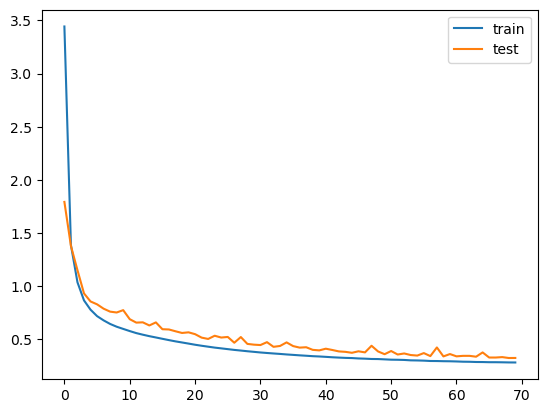

2670/2670 [==============================] - 4s 1ms/step


ValueError: Unable to coerce to Series/DataFrame, dimension must be <= 2: (85434, 1, 1)

In [25]:
from tensorflow.keras import optimizers
# 1. Update the LSTM model with the new parameters
learning_rate = Attacker_pos[0]  # learning rate
batch_size = int(Attacker_pos[1])  # batch size (convert to integer)
epochs = int(Attacker_pos[2])  # number of epochs (convert to integer)

model = create_attention_model((X_train.shape[1], X_train.shape[2]))
model.compile(loss='mae', optimizer=optimizers.Adam(lr=learning_rate))

# 2. Train the LSTM model using the updated parameters
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# 3. Plot the new loss curve based on the training process
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. Calculate the Mean Absolute Error (MAE) using the updated model
y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error (MAE):", mae)

In [28]:
y_pred = y_pred.flatten()  # Reshape y_pred to 1D array
y_test = y_test.to_numpy().flatten()  # Convert y_test to NumPy array and reshape to 1D array

mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.32214075515848295


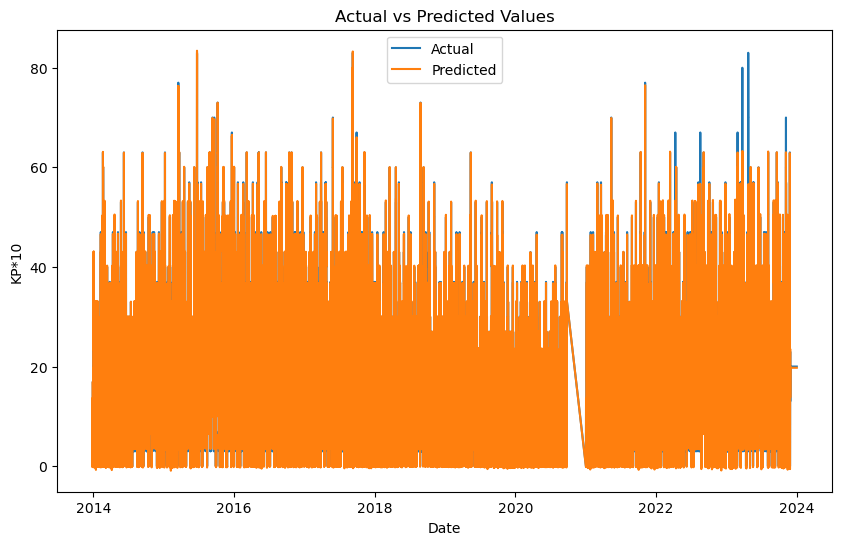

In [29]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Actual': np.array(y_test).flatten(), 
                        'Predicted': np.array(y_pred).flatten()
                       },
                       index=X['date'][train_size:])


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Actual'], label='Actual')
plt.plot(df_plot['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('KP*10')
plt.legend()
plt.show()

# ARIMA - CHIMP

In [74]:
from statsmodels.tsa.arima.model import ARIMA

# Define function to create ARIMA model
def create_arima_model(order):
    return ARIMA(endog=y_train, order=order)

# Define objective function for Chimp optimization
def objective_function(params):
    # Extract parameters for ARIMA model
    order = params.astype(int)
    
    # Construct and train ARIMA model using the parameters
    model = create_arima_model(order)
    model_fit = model.fit()
    
    # Make predictions
    y_pred = model_fit.forecast(steps=len(y_test))[0]
    
    # Calculate Mean Absolute Error (MAE) as the loss
    loss = np.mean(np.abs(y_test - y_pred))
    
    # Return loss (to minimize)
    return loss

# Function to evaluate the ARIMA model's performance
def evaluate_model(X_train, y_train, X_test, y_test, params):
    # Extract parameters for ARIMA model
    order = params.astype(int)
    
    # Construct and train ARIMA model using the parameters
    model = create_arima_model(order)
    model_fit = model.fit()
    
    # Make predictions
    y_pred = model_fit.forecast(steps=len(y_test))[0]
    
    # Calculate Mean Absolute Error (MAE) as the evaluation metric
    mae = np.mean(np.abs(y_test - y_pred))
    
    return mae


In [ ]:
#Scale the features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X.drop(["date"], axis=1)), columns=X.drop(["date"], axis=1).columns)

# Split the data into training and test sets
train_size = int(len(df_scaled) * 0.8)
X_train, X_test = df_scaled[:train_size], df_scaled[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define search space for Chimp optimization (e.g., learning rate, batch size, epochs)
lb = np.array([0.001, 32, 10])  # Lower bounds for parameters
ub = np.array([0.01, 128, 100])  # Upper bounds for parameters
dim = len(lb)  # Dimension of the search space

# Define other hyperparameters for Chimp optimization
SearchAgents_no = 30
Max_iter = 1

# Initialize search agents
Positions = initialization(SearchAgents_no, dim, ub, lb)

# Run Chimp optimization to find optimal parameters for LSTM
Attacker_score, Attacker_pos, Convergence_curve = Chimp(SearchAgents_no, Max_iter, lb, ub, dim, objective_function)

# Extract optimal parameters for LSTM model
best_params = Attacker_pos

C:\Users\omark\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
best_params

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Update the ARIMA model with the new parameters
order = (5, 1, 0)  # Example order, replace with Attacker_pos
model = ARIMA(endog=y_train, order=order)

# 2. Train the ARIMA model using the updated parameters
model_fit = model.fit()

# 3. Plot the residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# 4. Calculate the Mean Absolute Error (MAE) using the updated model
y_pred = model_fit.forecast(steps=len(y_test))[0]
mae = np.mean(np.abs(y_pred - y_test))
print("Mean Absolute Error (MAE):", mae)

In [ ]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Actual': np.array(y_test).flatten(), 
                        'Predicted': np.array(y_pred).flatten()
                       },
                       index=X['date'][train_size:])


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_plot['Actual'], label='Actual')
plt.plot(df_plot['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('KP*10')
plt.legend()
plt.show()